In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree

In [2]:
halos = {}
halos['lcdm'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_M13.npy')
halos['m26'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_1_26_10_M13.npy')
halos['m25'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_1_25_10_M13.npy')
halos['m24'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_1_24_10_M13.npy')
halos['m23'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_1_23_10_M13.npy')

voids = {}
voids['lcdm'] = np.loadtxt('2048Mpc_n4096_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m26'] = np.loadtxt('2048Mpc_n4096_1_26_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m25'] = np.loadtxt('2048Mpc_n4096_1_25_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m24'] = np.loadtxt('2048Mpc_n4096_1_24_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m23'] = np.loadtxt('2048Mpc_n4096_1_23_10_M13zobov-Voids_cat.txt', dtype=np.float32)    

hx = {}
hy = {}
hz = {}

vx = {}
vy = {}
vz = {}
vR = {}
vdelmin = {}
vdelavg = {}

for K in halos.keys():
    hx[K], hy[K], hz[K] = halos[K][:, :3].T + 1024 * .68
    vx[K] = (voids[K][:,1]-1024*.68)%(2048*.68)
    vy[K] = (voids[K][:,2]-1024*.68)%(2048*.68)
    vz[K] = (voids[K][:,3]-1024*.68)%(2048*.68)
    vR[K] = voids[K][:,4]
    vdelmin[K] = voids[K][:,5]
    vdelavg[K] = voids[K][:,6]

In [11]:
def clean_void_catalog(sim_key, boxsize=2048*.68):
    
        
    vol = boxsize**3
    halo_mean_dens = len(halos[sim_key])/vol
    mean_sep = (1/halo_mean_dens)**(1/3)
        
    ref_dens = -0.7
        
    pos = np.array([hx[sim_key], hy[sim_key], hz[sim_key]]).T
    tree = KDTree(pos, boxsize=2048*.68)

    pos_v = np.array([vx[sim_key], vy[sim_key], vz[sim_key]]).T
    tree_v = KDTree(pos_v, boxsize=2048*.68)
    
    dist_mat = tree_v.sparse_distance_matrix(tree_v, 100, output_type='dict')
    
    
    # Begin filter procedure: resize voids
    new_radii = []
    cs = np.linspace(0.7, 6, 100)

    for void_index in range(len(vx[sim_key])):
    
        void_radius = vR[sim_key][void_index]
        void_center = np.array([vx[sim_key][void_index], vy[sim_key][void_index], vz[sim_key][void_index]])
        void_dens = tree.query_ball_point(void_center, void_radius, return_length=True)
        void_dens /= (4*np.pi/3 * void_radius**3)
    
        if void_radius < 2.*mean_sep or void_dens > 0.55*halo_mean_dens:
            new_radii.append(0)
        else:
            for i in range(100):
                n_halos_in_void = tree.query_ball_point(void_center, void_radius/cs[i], return_length=True)
                void_vol = 4*np.pi/3*(void_radius/cs[i])**3
                void_mean_dens = n_halos_in_void/void_vol/halo_mean_dens-1
                if void_mean_dens <= ref_dens:

                    new_radii.append(void_radius/((cs[i-1]+cs[i])/2))
                    #print("======")
                    break
                elif i == 99:
                    new_radii.append(0)
                    
    
    # Step 2 reject voids which overlap
    rejected = np.zeros(len(vx[sim_key]))
    
    for i in range(len(vx[sim_key])):
        for j in tree_v.query_ball_point(pos_v[i], 100):
            dist = dist_mat[(i, j)]
            if dist == 0: dist = 1000 # very far away
            Ri = new_radii[i]
            Rj = new_radii[j]
            if Ri == 0:
                rejected[i] = 1
            elif Rj == 0:
                rejected[j] = 1
            else:
                Rt =  Ri + Rj
                if dist/Rt < 1:
                    if vdelmin[sim_key][i] < vdelmin[sim_key][j]: # keep more underdense void?
                        rejected[i] = 1
                    else:
                        rejected[j] = 1
                        
    #print(len(np.array(new_radii)[rejected==0])/len(new_radii))
    
    return np.array(new_radii)[rejected==0]

In [81]:
clean_void_catalog('m26') #- np.array(new_radii)[rejected==0]

array([48.21347207, 48.65380671, 27.01057839, 49.9579603 , 29.07512878,
       48.52307369, 44.1557385 , 36.75087439, 33.66562255, 35.2112789 ,
       48.24670463, 52.84837229, 34.68382339, 50.33301166, 38.1166427 ,
       38.28181502, 29.59541467, 42.91972057, 42.8609645 , 40.33843838,
       38.96926332, 43.20676716, 35.98644976, 39.42156118, 30.450426  ,
       35.62102296, 42.17573721, 44.25932474, 38.28278739, 35.07689445,
       41.98295166, 36.42074281, 41.60178894, 42.18335327, 33.9799933 ,
       23.08638216, 32.50673796, 44.29379155, 40.01508565, 33.52926601,
       38.3198867 , 21.93937988, 33.90854473, 45.35834065, 38.81181666,
       40.40162161, 35.46172867, 39.64539036, 30.46612502, 38.59613545,
       39.54370301, 50.84044558, 31.0570966 , 27.76163155, 37.81709341,
       39.01545796, 33.58056757, 31.71663063, 34.13142787, 35.91018155,
       42.23711352, 41.81746837, 37.59316211, 17.8969341 ,  9.26865649,
       42.15816406, 28.25620952, 31.1174536 , 32.23249093, 38.12

In [5]:
#plt.hist(vdelmin['lcdm'], bins=50)

In [8]:
0.2*halo_mean_dens

0.00014307031049394064

In [4]:
'''%%time

new_radii = []
cs = np.linspace(0.7, 6, 100)

for void_index in range(len(vx['lcdm'])):
    
    void_radius = vR['lcdm'][void_index]
    void_center = np.array([vx['lcdm'][void_index], vy['lcdm'][void_index], vz['lcdm'][void_index]])
    void_dens = tree.query_ball_point(void_center, void_radius, return_length=True)
    void_dens /= (4*np.pi/3 * void_radius**3)
    
    if void_radius < 2.3*mean_sep or void_dens > 0.55*halo_mean_dens:
        new_radii.append(0)
    else:
        
    

        for i in range(100):
            n_halos_in_void = tree.query_ball_point(void_center, void_radius/cs[i], return_length=True)
            void_vol = 4*np.pi/3*(void_radius/cs[i])**3
            void_mean_dens = n_halos_in_void/void_vol/halo_mean_dens-1
            #print(vdelavg['lcdm'][void_index], void_mean_dens)
            if void_mean_dens <= ref_dens:
            
                new_radii.append(void_radius/((cs[i-1]+cs[i])/2))
                #print("======")
                break
            elif i == 99:
                new_radii.append(0)
                
                
    
   '''

'%%time\n\nnew_radii = []\ncs = np.linspace(0.7, 6, 100)\n\nfor void_index in range(len(vx[\'lcdm\'])):\n    \n    void_radius = vR[\'lcdm\'][void_index]\n    void_center = np.array([vx[\'lcdm\'][void_index], vy[\'lcdm\'][void_index], vz[\'lcdm\'][void_index]])\n    void_dens = tree.query_ball_point(void_center, void_radius, return_length=True)\n    void_dens /= (4*np.pi/3 * void_radius**3)\n    \n    if void_radius < 2.3*mean_sep or void_dens > 0.55*halo_mean_dens:\n        new_radii.append(0)\n    else:\n        \n    \n\n        for i in range(100):\n            n_halos_in_void = tree.query_ball_point(void_center, void_radius/cs[i], return_length=True)\n            void_vol = 4*np.pi/3*(void_radius/cs[i])**3\n            void_mean_dens = n_halos_in_void/void_vol/halo_mean_dens-1\n            #print(vdelavg[\'lcdm\'][void_index], void_mean_dens)\n            if void_mean_dens <= ref_dens:\n            \n                new_radii.append(void_radius/((cs[i-1]+cs[i])/2))\n              

In [70]:
#len(np.array(new_radii)[np.array(new_radii)>0])/len(new_radii)

0.08215978108522992

In [17]:
#dist_mat = tree_v.sparse_distance_matrix(tree_v, 100, output_type='dict')

In [5]:



'''rejected = np.zeros(len(vx['lcdm']))

for i in range(len(vx['lcdm'])):
    if i % 1000 == 0:
        print(str(i/14983))
    for j in tree_v.query_ball_point(pos_v[i], 100):
        dist = dist_mat[(i, j)]
        if dist == 0: dist = 1000 # very far away
        Ri = new_radii[i]
        Rj = new_radii[j]
        if Ri == 0:
            rejected[i] = 1
        elif Rj == 0:
            rejected[j] = 1
        else:
            Rt =  Ri + Rj
            if dist/Rt < 1:
                if vdelmin['lcdm'][i] < vdelmin['lcdm'][j]: # keep more underdense void?
                    rejected[i] = 1
                else:
                    rejected[j] = 1'''

"rejected = np.zeros(len(vx['lcdm']))\n\nfor i in range(len(vx['lcdm'])):\n    if i % 1000 == 0:\n        print(str(i/14983))\n    for j in tree_v.query_ball_point(pos_v[i], 100):\n        dist = dist_mat[(i, j)]\n        if dist == 0: dist = 1000 # very far away\n        Ri = new_radii[i]\n        Rj = new_radii[j]\n        if Ri == 0:\n            rejected[i] = 1\n        elif Rj == 0:\n            rejected[j] = 1\n        else:\n            Rt =  Ri + Rj\n            if dist/Rt < 1:\n                if vdelmin['lcdm'][i] < vdelmin['lcdm'][j]: # keep more underdense void?\n                    rejected[i] = 1\n                else:\n                    rejected[j] = 1"

In [65]:
len(rejected[rejected>0])/len(vx['lcdm'])

0.9337248882066342

In [20]:
len(new_radii), len(vx['lcdm'])

(14983, 14983)

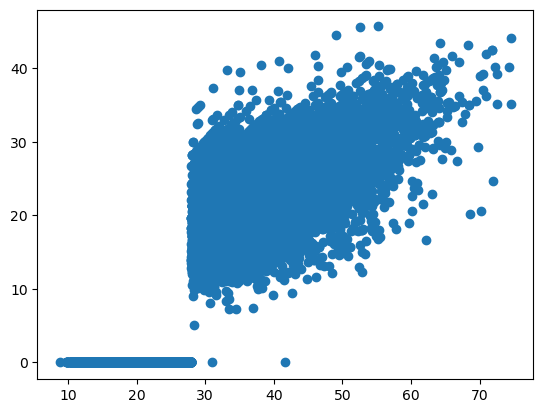

In [43]:
plt.scatter(voids['lcdm'][:,4], new_radii)

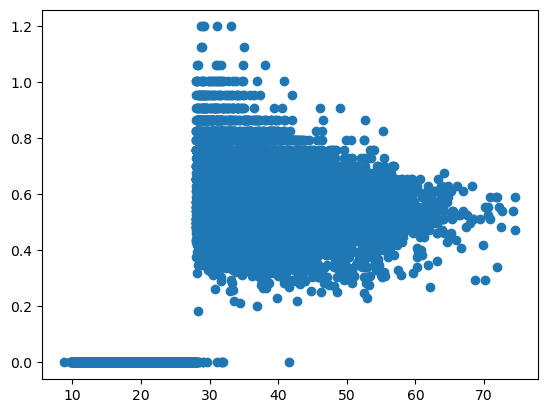

In [51]:
plt.scatter(voids['lcdm'][:,4], new_radii/voids['lcdm'][:,4])

In [66]:
len(np.array(new_radii)[rejected==0])/len(new_radii), 343/4989

(0.06627511179336582, 0.06875125275606334)

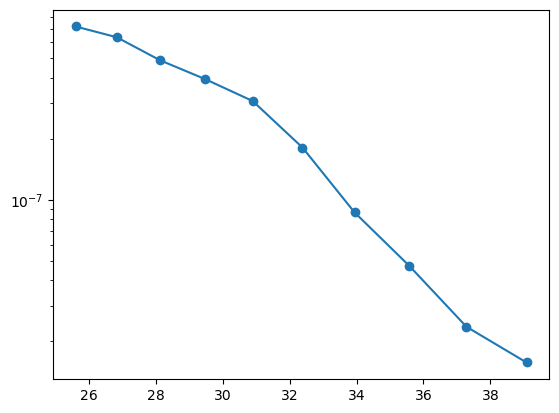

In [82]:
bin_edges    = np.geomspace(25, 40, 11)
bin_cens     = (bin_edges[:-1] + bin_edges[1:]) / 2#np.geomspace(25, 40, 10)
hist_void    = np.histogram(np.array(new_radii)[rejected==0], bins=bin_edges)
n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))

plt.semilogy(bin_cens, dn_dlnR_void, '-o')

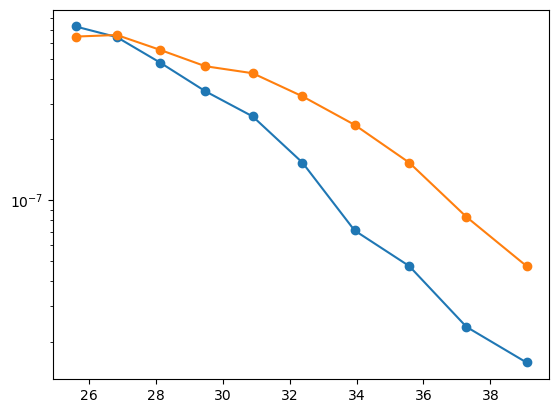

In [12]:
bin_edges    = np.geomspace(25, 40, 11)
bin_cens     = (bin_edges[:-1] + bin_edges[1:]) / 2#np.geomspace(25, 40, 10)
hist_void    = np.histogram(clean_void_catalog('lcdm'), bins=bin_edges)
n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))

plt.semilogy(bin_cens, dn_dlnR_void, '-o')

bin_edges    = np.geomspace(25, 40, 11)
bin_cens     = (bin_edges[:-1] + bin_edges[1:]) / 2#np.geomspace(25, 40, 10)
hist_void    = np.histogram(clean_void_catalog('m25'), bins=bin_edges)
n_of_R_void  = np.cumsum(hist_void[0]/(2048*.68)**3)
dn_dlnR_void = np.gradient(n_of_R_void, np.log(bin_cens))

plt.semilogy(bin_cens, dn_dlnR_void, '-o')


In [13]:
#np.savetxt('test_new_radii_lcdm.dat', np.array(new_radii)[rejected==0])
np.savetxt('test_new_radii_m25.dat', clean_void_catalog('m25'))
np.savetxt('test_new_radii_lcdm.dat', clean_void_catalog('lcdm'))